## Importing necessary Modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , r2_score , mean_absolute_error , make_scorer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold 
%matplotlib inline

## Loading the Dataset

In [2]:
df = pd.read_csv('gait.csv')
df.head()

,subject,condition,replication,leg,joint,time,angle
0,1,1,1,1,1,0,4.682881
1,1,1,1,1,1,1,5.073127
2,1,1,1,1,1,2,5.229774
3,1,1,1,1,1,3,5.083273
4,1,1,1,1,1,4,4.652399


### Checking for duplicates

In [3]:
df.duplicated().sum()

0

### Checking for NULL values

In [4]:
df.isnull().sum()

subject        0
condition      0
replication    0
leg            0
joint          0
time           0
angle          0
dtype: int64

## Understanding the Dataset

In [5]:
df.shape

(181800, 7)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181800 entries, 0 to 181799
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   subject      181800 non-null  int64  
 1   condition    181800 non-null  int64  
 2   replication  181800 non-null  int64  
 3   leg          181800 non-null  int64  
 4   joint        181800 non-null  int64  
 5   time         181800 non-null  int64  
 6   angle        181800 non-null  float64
dtypes: float64(1), int64(6)
memory usage: 9.7 MB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
subject,181800.0,5.500000,2.872289,1.000000,3.000000,5.500000,8.00000,10.000000
condition,181800.0,2.000000,0.816499,1.000000,1.000000,2.000000,3.00000,3.000000
replication,181800.0,5.500000,2.872289,1.000000,3.000000,5.500000,8.00000,10.000000
leg,181800.0,1.500000,0.500001,1.000000,1.000000,1.500000,2.00000,2.000000
joint,181800.0,2.000000,0.816499,1.000000,1.000000,2.000000,3.00000,3.000000
time,181800.0,50.000000,29.154840,0.000000,25.000000,50.000000,75.00000,100.000000
angle,181800.0,12.149321,16.025823,-27.004634,1.794457,9.466976,18.55989,78.309342


## Understanding the Target Variable

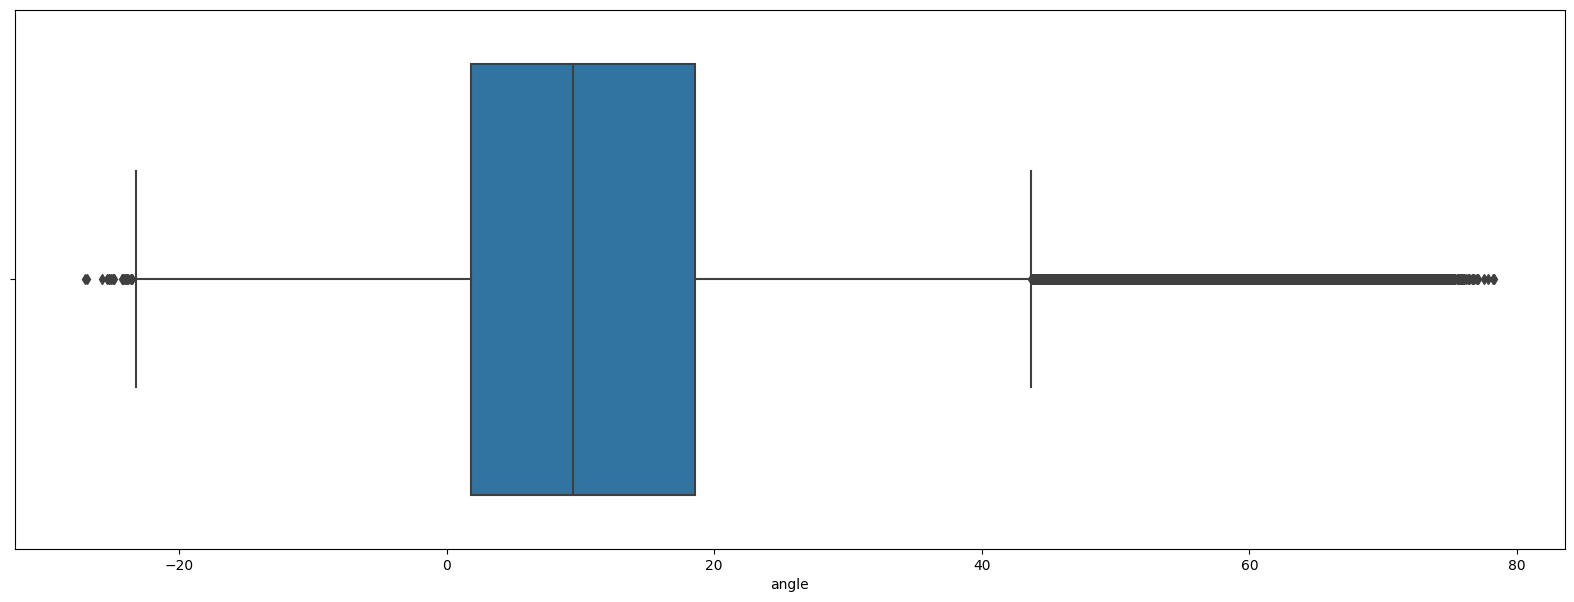

In [8]:
plt.figure(figsize=(20,7))
sns.boxplot(x = df['angle'])
plt.show()

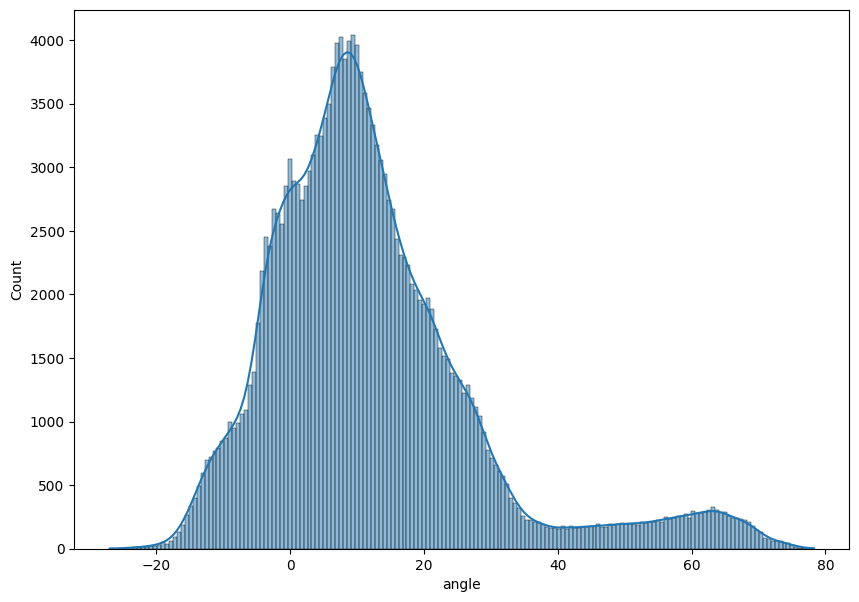

In [9]:
plt.figure(figsize=(10,7))
sns.histplot(data=df,x='angle',kde=True)
plt.show()

### Data for angle of different subjects

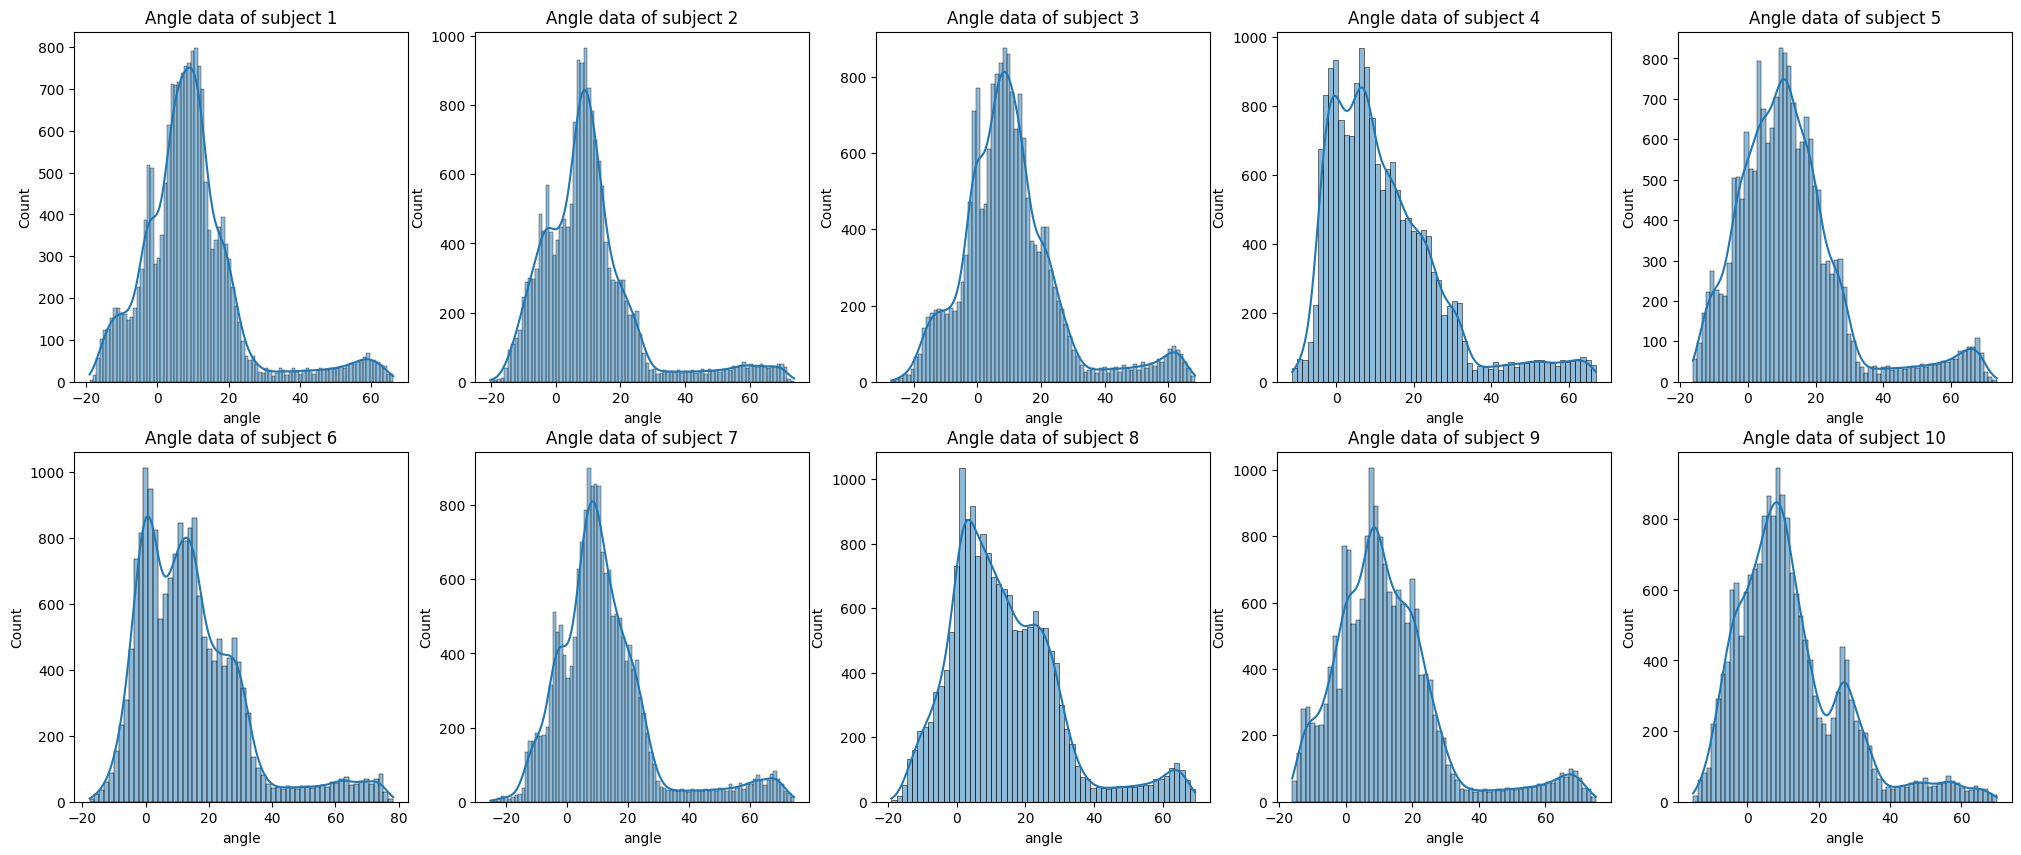

In [10]:
plt.figure(figsize=(25,10))
for i in range(1,11):
    subject_data = df[df['subject'] == i]
    plt.subplot(2,5,i)
    plt.title(f"Angle data of subject {i}")
    sns.histplot(data = subject_data , x = 'angle' , kde = True)
plt.show()

## Checking for Normal Outliers

In [12]:
def normalOutliers(df,col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)

    iqr = q3-q1

    upperl = q3+(1.5 * iqr)
    lowerl = q1-(1.5 * iqr)

    outliers = df[(df[col]>upperl)|(df[col]<lowerl)]
    return outliers

In [13]:
normalOutliers(df,'angle').shape

(10762, 7)

## Removing Extreme Outliers

In [14]:
def extremeOutliers(df,col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)

    iqr = q3-q1

    upperl = q3+(3 * iqr)
    lowerl = q1-(3 * iqr)

    outliers = df[(df[col]>upperl)|(df[col]<lowerl)]
    return outliers

def removeExOutliers(df,col):
    outliers = extremeOutliers(df,col)

    if outliers.empty:
        return df
    df.drop(outliers.index, inplace = True)
    return df.reset_index(drop = True)

In [15]:
extremeOutliers(df,'angle').shape

(948, 7)

In [16]:
dfn = removeExOutliers(df,'angle')

### Vizualing the target variable after removing extreme outliers

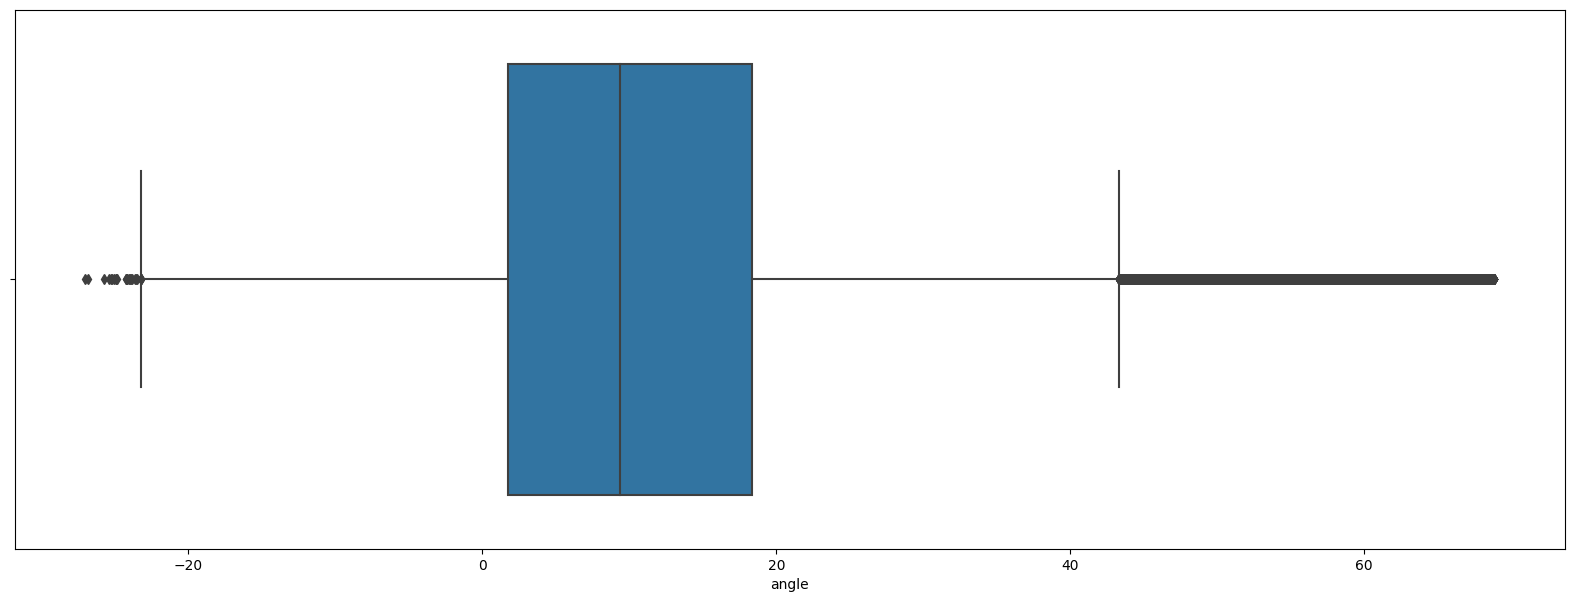

In [17]:
plt.figure(figsize=(20,7))
sns.boxplot(x = dfn['angle'])
plt.show()

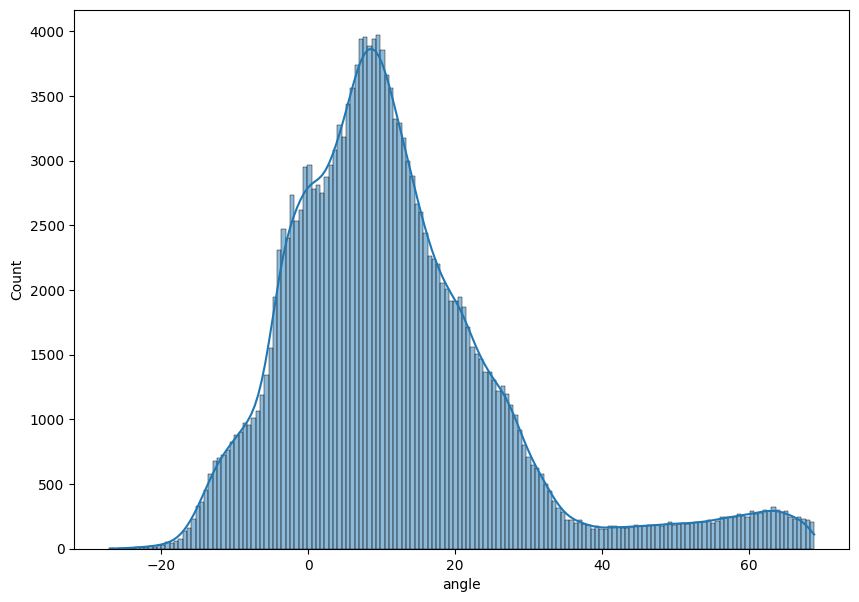

In [18]:
plt.figure(figsize=(10,7))
sns.histplot(data=dfn,x='angle',kde=True)
plt.show()

## Spliting dataset into training and testing sets

In [19]:
X = dfn.iloc[:,1:-1].values
y = dfn.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Building the Model

## Using XGBoost Regressor

In [20]:
xgb_model = XGBRegressor()

xgb_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
print(f"XGBoost RMSE: {xgb_rmse:.2f}")
print(f"XGBoost R2: {r2_score(y_test,xgb_predictions):.2f}")

XGBoost RMSE: 4.21
XGBoost R2: 0.93


## Using LightGBM Regressor

In [21]:
lgbm_model = LGBMRegressor()

lgbm_model.fit(X_train, y_train)

lgbm_predictions = lgbm_model.predict(X_test)
lgbm_rmse = np.sqrt(mean_squared_error(y_test, lgbm_predictions))
print(f"LightGBM RMSE: {lgbm_rmse:.2f}")
print(f"LightGBM R2: {r2_score(y_test,lgbm_predictions):.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 123
[LightGBM] [Info] Number of data points in the train set: 144681, number of used features: 5
[LightGBM] [Info] Start training from score 11.838287
LightGBM RMSE: 4.21
LightGBM R2: 0.93


## Performing 10-Fold Cross-Validation on XGBoost

In [22]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

fold_rmse_scores = []
fold_r2_scores = []
fold_mae_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    xgb_model = XGBRegressor(random_state=42)
    xgb_model.fit(X_train_fold, y_train_fold)
    
    y_pred_fold = xgb_model.predict(X_test_fold)
    
    rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
    r2 = r2_score(y_test_fold, y_pred_fold)
    mae = mean_absolute_error(y_test_fold, y_pred_fold)
    
    fold_rmse_scores.append(rmse)
    fold_r2_scores.append(r2)
    fold_mae_scores.append(mae)
    
    print(f"Fold {fold}: RMSE = {rmse:.4f}, R2 = {r2:.4f} , MAE = {mae:.4f}")

print(f"\nAverage RMSE: {np.mean(fold_rmse_scores):.4f} ± {np.std(fold_rmse_scores):.4f}")
print(f"Average R2: {np.mean(fold_r2_scores):.4f} ± {np.std(fold_r2_scores):.4f}")
print(f"Average MAE: {np.mean(fold_mae_scores):.4f} ± {np.std(fold_mae_scores):.4f}")

Fold 1: RMSE = 4.1762, R2 = 0.9288 , MAE = 3.2610
Fold 2: RMSE = 4.2072, R2 = 0.9252 , MAE = 3.2852
Fold 3: RMSE = 4.1656, R2 = 0.9289 , MAE = 3.2532
Fold 4: RMSE = 4.1675, R2 = 0.9271 , MAE = 3.2546
Fold 5: RMSE = 4.1819, R2 = 0.9270 , MAE = 3.2594
Fold 6: RMSE = 4.1531, R2 = 0.9270 , MAE = 3.2241
Fold 7: RMSE = 4.1743, R2 = 0.9258 , MAE = 3.2520
Fold 8: RMSE = 4.1978, R2 = 0.9291 , MAE = 3.2653
Fold 9: RMSE = 4.2800, R2 = 0.9221 , MAE = 3.3260
Fold 10: RMSE = 4.1407, R2 = 0.9279 , MAE = 3.2344

Average RMSE: 4.1844 ± 0.0368
Average R2: 0.9269 ± 0.0020
Average MAE: 3.2615 ± 0.0266


## Performing 10-Fold Cross-Validation on LGBM

In [23]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

fold_rmse_scores = []
fold_r2_scores = []
fold_mae_scores = []

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    lgbm_model = LGBMRegressor(random_state=42)
    lgbm_model.fit(X_train_fold, y_train_fold)
    
    y_pred_fold = lgbm_model.predict(X_test_fold)
    
    rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
    r2 = r2_score(y_test_fold, y_pred_fold)
    mae = mean_absolute_error(y_test_fold, y_pred_fold)
    
    fold_rmse_scores.append(rmse)
    fold_r2_scores.append(r2)
    fold_mae_scores.append(mae)
    
    print(f"Fold {fold}: RMSE = {rmse:.4f}, R2 = {r2:.4f} , MAE = {mae:.4f}")

print(f"\nAverage RMSE: {np.mean(fold_rmse_scores):.4f} ± {np.std(fold_rmse_scores):.4f}")
print(f"Average R2: {np.mean(fold_r2_scores):.4f} ± {np.std(fold_r2_scores):.4f}")
print(f"Average MAE: {np.mean(fold_mae_scores):.4f} ± {np.std(fold_mae_scores):.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 123
[LightGBM] [Info] Number of data points in the train set: 162766, number of used features: 5
[LightGBM] [Info] Start training from score 11.828963
Fold 1: RMSE = 4.1959, R2 = 0.9281 , MAE = 3.2721
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 123
[LightGBM] [Info] Number of data points in the train set: 162766, number of used features: 5
[LightGBM] [Info] Start training from score 11.848520
Fold 2: RMSE = 4.2192, R2 = 0.9248 , MAE = 3.2916
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.